# DFT atom

In [1]:
using Pkg;
Pkg.activate("../../SchrodingerEquationSolver");
include("../src/SchrodingerEquationSolver.jl");
import .SchrodingerEquationSolver as ses
import .ses.Grids as Grids
import .ses.Potentials as Potentials
import .ses.MathUtils as MathUtils
import .ses.Hydrogen as Hydrogen
import .ses.InitialConditions as InitialConditions
import .ses.OneDSchrodingerEquationSolver as odses
import .ses.OneDPoissonEquationSolver as odpes
import .ses.EigenvalueFinders as EigenvalueFinders
import .ses.AtomBasisSet as AtomBasisSet
import .ses.Density as Density
import .ses.ExchangeCorrelation as ExchangeCorrelation
using Plots

  Activating project at `~/Desktop/physics_coding_projects/julia/SchrodingerEquationSolver`


In [2]:
#Define parameters and produce an exponential grid.
r_max::Float64=30.0;#Max radius of space grid.
Z::Int64=36;#Atomic number, also used as the charge of coulomb potential.

In [3]:

#grid definition
grid_stru= Grids.init_exponential_grid_structure(r_max, Z);
N=grid_stru.N;
print("grid size ", N)

grid size 8391

In [4]:
#Initialization of potentials and energies

#Initializing coulomb potential due to nuclei charge.
V_colu::Vector{Float64}= Potentials.coulomb_potential(Z, grid_stru.grid);
#Initializing Hartree potential due to electron density. 
V_hartree::Vector{Float64}=zeros(Float64, N);
#Initializing exchange potential.
V_x::Vector{Float64}=zeros(Float64, N);
#Initializing correlation potential.
V_c::Vector{Float64}=zeros(Float64, N);
#Initializing energy exchange potential.
E_xp::Vector{Float64}=zeros(Float64, N);
#Initializing energy correlation potential.
E_cp::Vector{Float64}=zeros(Float64, N);
#Initializing exchange + correlation potential.
V_xcp::Vector{Float64}=zeros(Float64, N);
#Initializing the density.
density_in::Vector{Float64}= zeros(Float64, N);
#Initializing total energy
E_total::Float64=1.0;
#Initializing total energy step before
E_total_before::Float64=2.0;
#Initializing energy from energy eigenvalues
E_eigen::Float64=0.0;
#Initializing exchange correlation potential value after integral
V_xc::Float64= 0.0;
#Initializing Hartree energy
E_hartree::Float64= 0.0;
#Initializing exchange energy
E_x::Float64= 0.0;
#Initializing correlation enrgy
E_c::Float64= 0.0;
#Initializing basis set data structure
basis= AtomBasisSet.init_atom_basis_set(Z, grid_stru.grid);

In [6]:
#Energy minimization loop 
while abs(E_total - E_total_before) > 10.0e-8
    E_eigen=0.0;
    #Loop over every orbital to solve independent particle Schrodinger equation.
    for i_orbi in basis.orbitals
        #println(i_orbi.name)
        #angular potential for l orbital
        V_angu= Potentials.angular_potential(i_orbi.l, grid_stru.grid);
        #Assemble effective potential.
        V_effe= V_colu .+ V_angu .+ V_hartree .+ V_x .+ V_c;
        V_effe_max= maximum(V_effe)
        V_effe_min= minimum(V_effe)
        energy_interval= EigenvalueFinders.guess_energy_interval(i_orbi.E, V_effe_max, V_effe_min);

        u_temp, ei_temp= EigenvalueFinders.illinois_eigenvalue_finder(energy_interval, V_effe, 
        grid_stru,InitialConditions.atom_exponential_grid, 
        odses.solver_exponential_grid ,
        l=i_orbi.l);
        #Update eigenvalue and eigenfunction in the basis set data structure.
        i_orbi.E=ei_temp;
        i_orbi.u=u_temp;
        E_eigen+= i_orbi.occu*ei_temp;
        #println(i_orbi.E)
        #println("--------------------------------")

    end
    #Update E_total_before from the E_total from the previous step.
    E_total_before= float(E_total);
    #Calculate density with new basis set.
    density_out= Density.calculate_density(basis);
    #Smooth the density with linear mixing (combination) of the previous and current densities.
    density_in= Density.linear_mixing(density_in, density_out, alpha=0.10);
    #Solve Poisson equation to find the new Hartree potential.
    V_hartree= odpes.solver_exponential_grid(Z, density_in, grid_stru);
    #Calculate new exchange and correlation potentials.
    V_x, E_xp, V_c, E_cp= ExchangeCorrelation.potentials(density_in);
    #Add exchange and correlation potentials.
    V_xcp= V_x .+ V_c;
    #Integrals to calculate energy components.

    V_xc= 4.0*pi*MathUtils.energy_integral_exponential_grid(grid_stru, density_in, V_xcp)

    E_hartree= 0.5*4.0*pi*MathUtils.energy_integral_exponential_grid(grid_stru, density_in, V_hartree);

    E_x= 4.0*pi*MathUtils.energy_integral_exponential_grid(grid_stru, density_in, E_xp);

    E_c= 4.0*pi*MathUtils.energy_integral_exponential_grid(grid_stru, density_in, E_cp);

    #Calculate total energy.
    E_total= E_eigen - E_hartree + E_x + E_c - V_xc;

    #println("*****************************************")
end
println("E_hartree ", E_hartree)
println("E_x + E_c ", (E_x + E_c))
println("E_total ", E_total)
for i_orbi in basis.orbitals
    println(i_orbi.name)
    println(i_orbi.E)
end

E_hartree 1171.741073307797
E_x + E_c -91.81965037401008
E_total -2750.14794069803
1s
-509.9847727505466
2s
-66.28797772894227
2p
-60.019336530834515
3s
-9.31730881886508
3p
-7.088749912259615
4s
-0.8226771293161645
3d
-3.076225825677448
4p
-0.3484031615384158


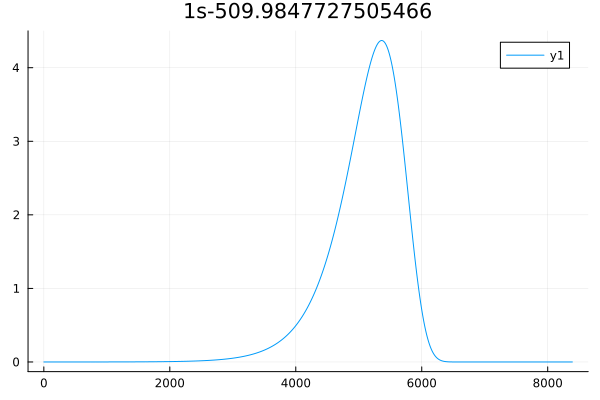

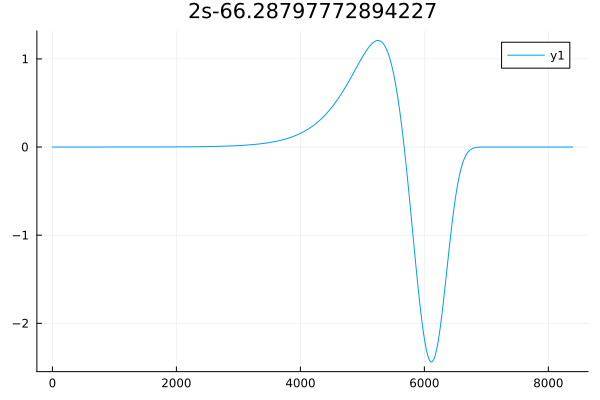

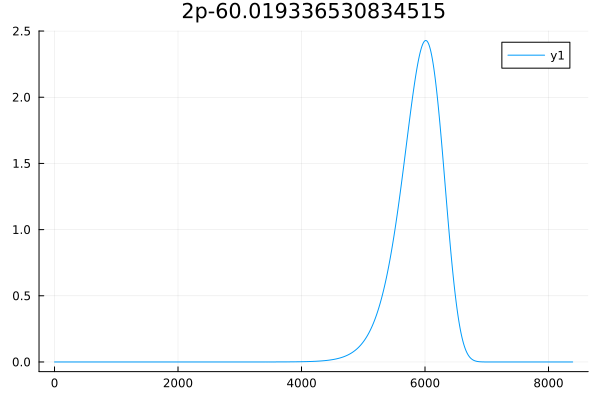

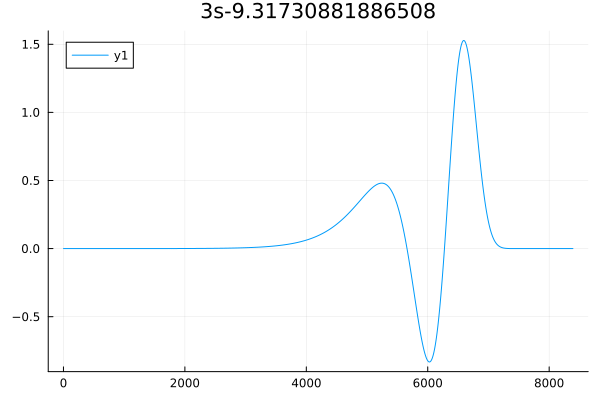

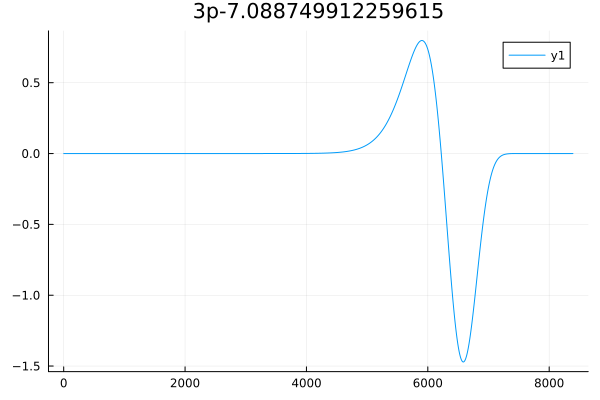

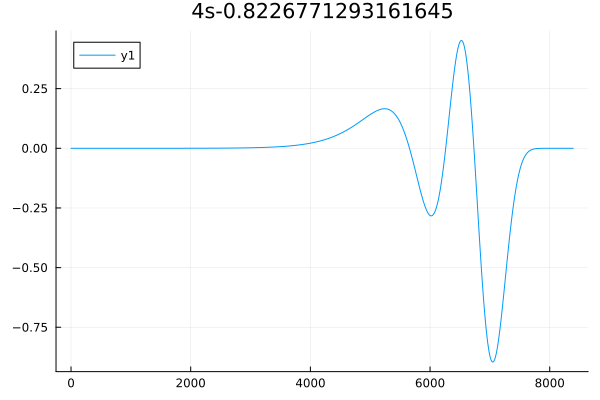

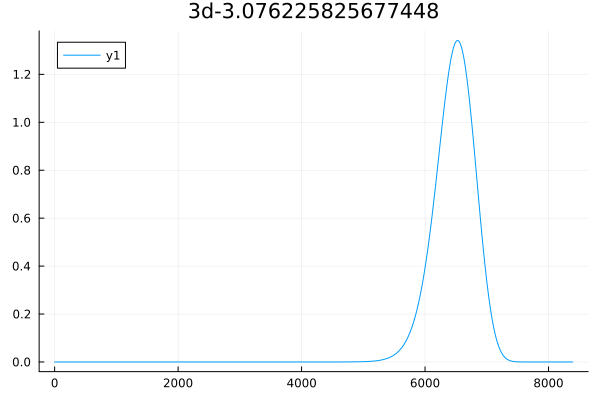

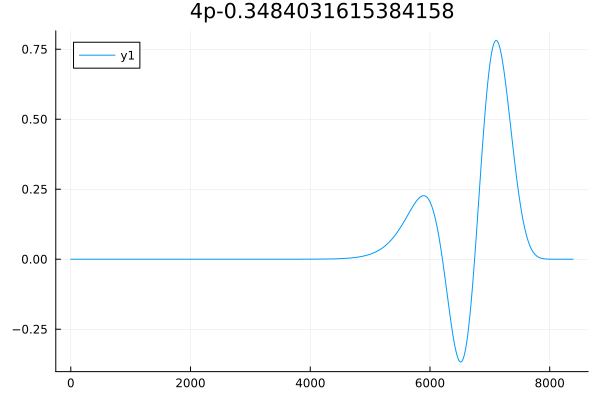

In [7]:
for i_orbi in basis.orbitals
    #println(i_orbi.name)
    #println(i_orbi.E)
    Plots.display(plot(grid_stru.grid_i, i_orbi.u, title= string(i_orbi.name,i_orbi.E)))
end